# Удаляем точки с недопустимыми NaN

In [1]:
import pandas as pd

from utils import definitions as defs
from utils import visualization as viz

In [2]:
df = pd.read_excel(defs.ETLED_DATA_PATH_step_1)

In [3]:
# для визуализации распределения по классами
norm_old = (df[defs.LABEL] == defs.LABELS[0]).sum()
benign_tumor_old = (df[defs.LABEL] == defs.LABELS[1]).sum()
malignant_tumor_old = (df[defs.LABEL] == defs.LABELS[2]).sum()

### 2. Возраст

In [4]:
df = df[df[defs.QUESTION_2].notnull()]  # 595 - 2 = 593

### 5. В какой семье Вы выросли?

In [5]:
df = df[df[defs.QUESTION_5].isin(defs.ANSWERS_5)]  # 593 - 1 = 592

### 12. Сколько человек живут вместе с Вами?

In [6]:
df = df[df[defs.QUESTION_12].isin(defs.ANSWERS_12)]  # 592 - 2 = 590

### 15. Есть ли у Вас домашние питомцы? (да/нет)

In [7]:
df = df[df[defs.QUESTION_15].isin([defs.YES, defs.NO])]  # 590 - 1 = 589

### 16. В течение последних 7 дней, как часто Вы практиковали тяжелые физические нагрузки?

In [8]:
df = df[df[defs.QUESTION_16].isin(defs.ANSWERS_16_17_18)]  # 589 - 2 = 587

### 17. В течение последних 7 дней, как часто Вы практиковали умеренные физические нагрузки?

In [9]:
df = df[df[defs.QUESTION_17].isin(defs.ANSWERS_16_17_18)]  # 587 - 1 = 586

### 22. Как долго Вы проживаете в этом месте? (в годах)

In [10]:
df = df[df[defs.QUESTION_22].notnull()]  # 586 - 5 = 581

### 25. Каким транспортом Вы обычно пользуетесь?

In [11]:
df = df[df[defs.QUESTION_25].notnull()]  # 581 - 1 = 580

In [12]:
# для визуализации распределения по классами
norm_new = (df[defs.LABEL] == defs.LABELS[0]).sum()
benign_tumor_new = (df[defs.LABEL] == defs.LABELS[1]).sum()
malignant_tumor_new = (df[defs.LABEL] == defs.LABELS[2]).sum()

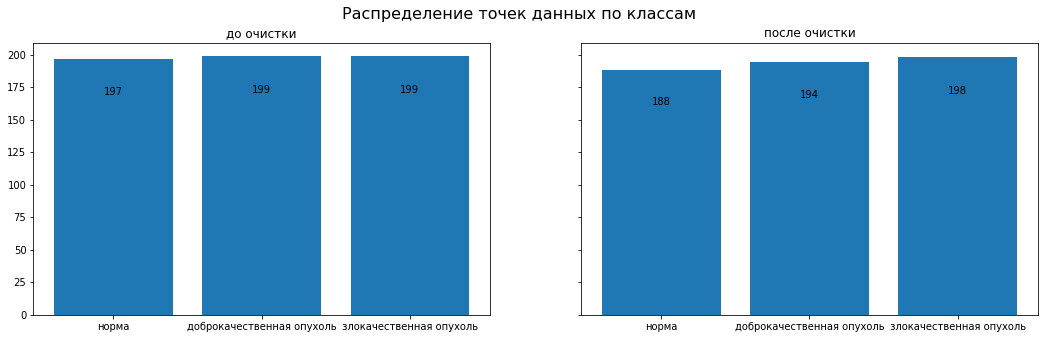

In [13]:
viz.plot_distribution(
    norm_old, benign_tumor_old, malignant_tumor_old,
    norm_new, benign_tumor_new, malignant_tumor_new,
)

In [14]:
df.to_excel(excel_writer=defs.ETLED_DATA_PATH_step_2, index=False)

# Разведочный анализ данных

### 2. Возраст

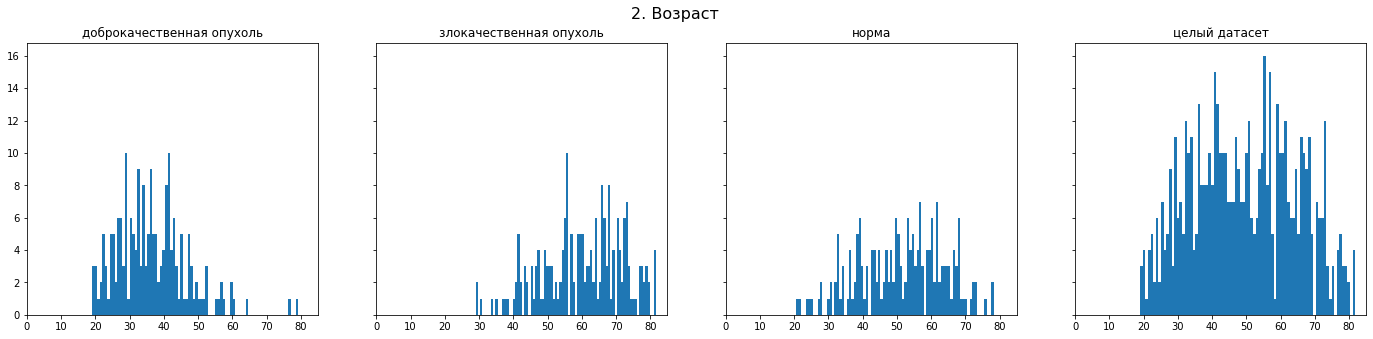

In [15]:
viz.plot_hists(df, defs.QUESTION_2, defs.LABEL, bins=82, xlim=(0, 85))

### 3. Семейное положение

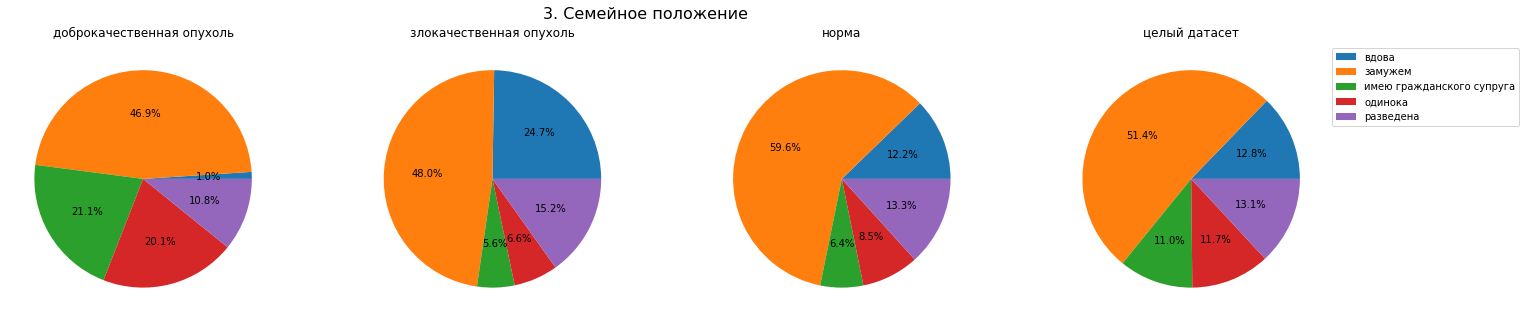

In [16]:
viz.plot_pies(df, defs.QUESTION_3, defs.LABEL)

### 4. Если имеете супруга или партнёра, как долго вы живёте вместе (в годах)?

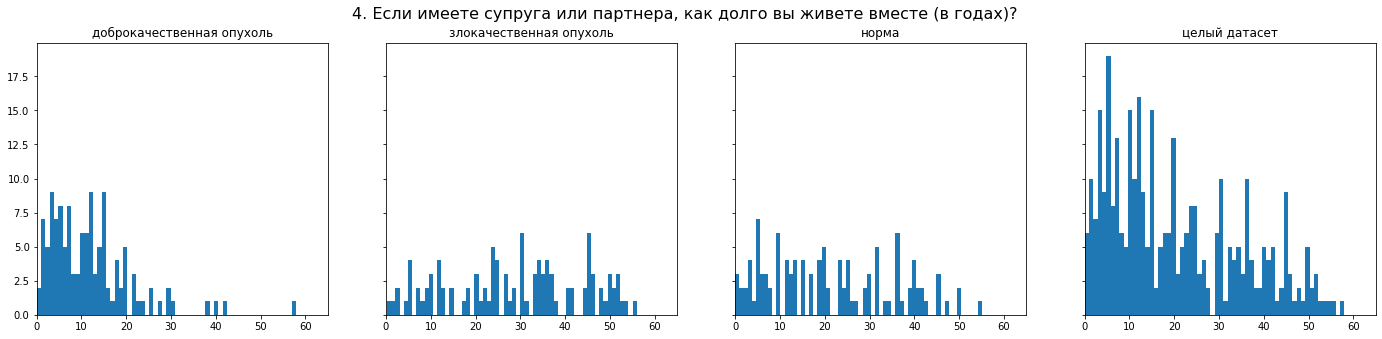

In [17]:
viz.plot_hists(df, defs.QUESTION_4, defs.LABEL, bins=60, xlim=(0, 65))

### 5. В какой семье Вы выросли?

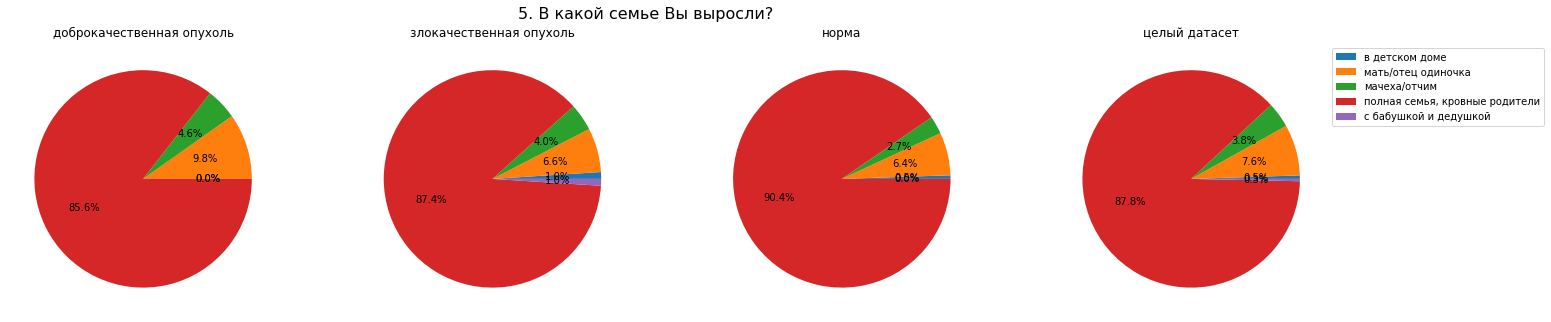

In [18]:
viz.plot_pies(df, defs.QUESTION_5, defs.LABEL)

### 6. Жив ли хотя бы один из Ваших родителей? (да/нет)

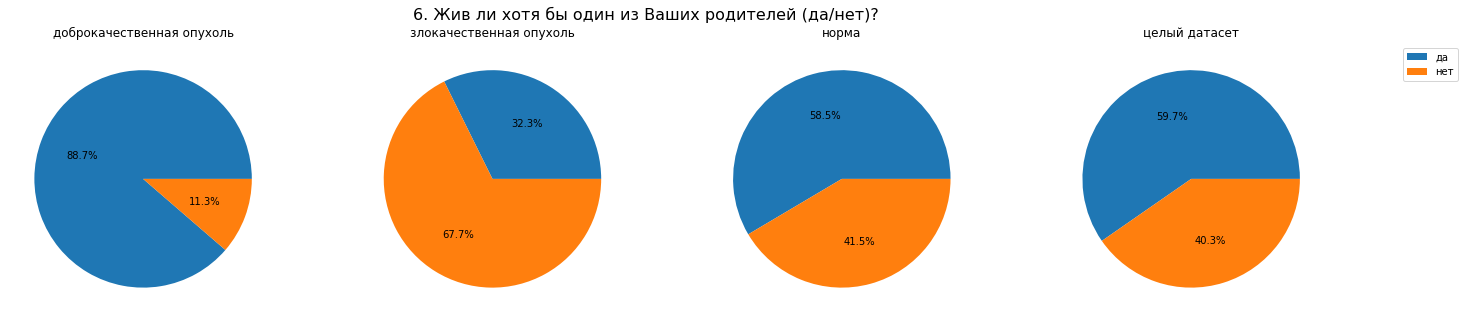

In [19]:
viz.plot_pies(df, defs.QUESTION_6, defs.LABEL)

### 7. Если да, как часто вы общаетесь?

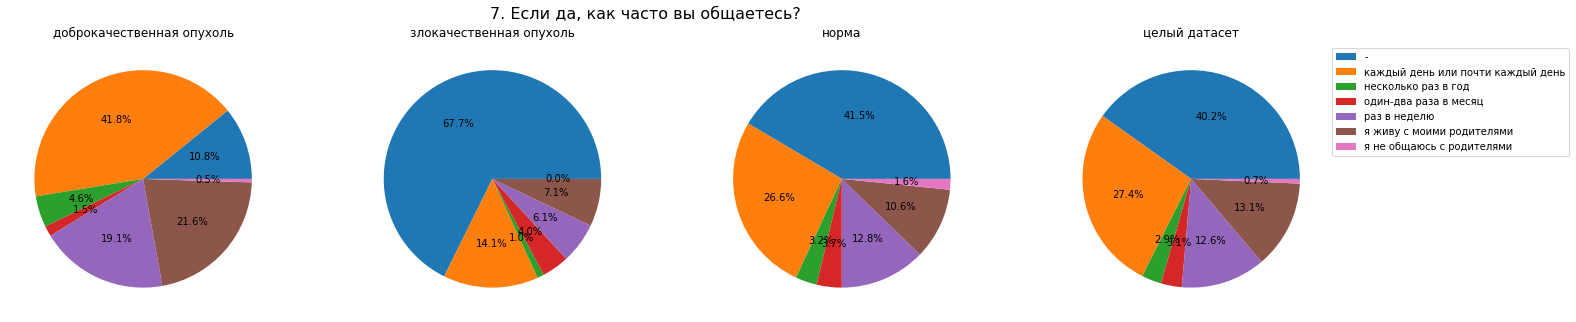

In [20]:
viz.plot_pies(df, defs.QUESTION_7, defs.LABEL)

### 8. Есть ли у Вас дети? (да/нет)

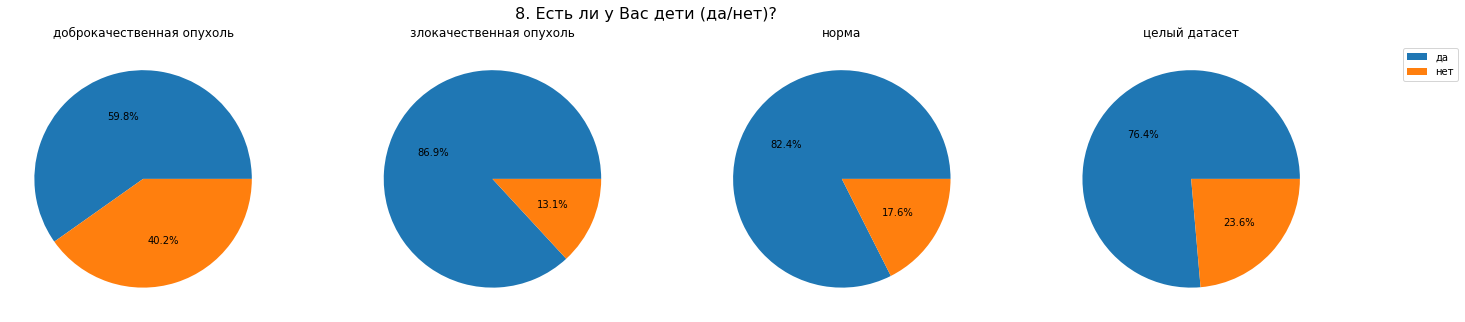

In [21]:
viz.plot_pies(df, defs.QUESTION_8, defs.LABEL)

### 9. Сколько у Вас детей?

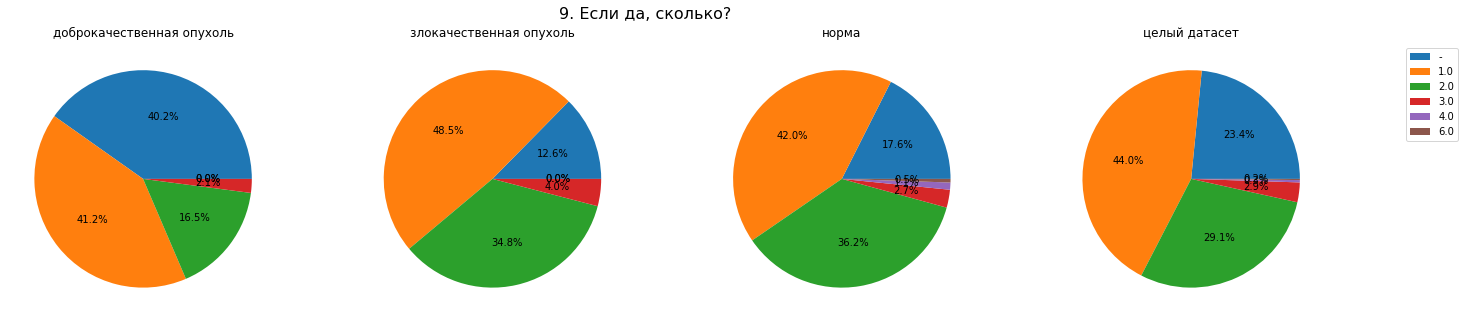

In [22]:
viz.plot_pies(df, defs.QUESTION_9, defs.LABEL)

### 11. Если да, как часто вы общаетесь? (с совершеннолетними детьми)

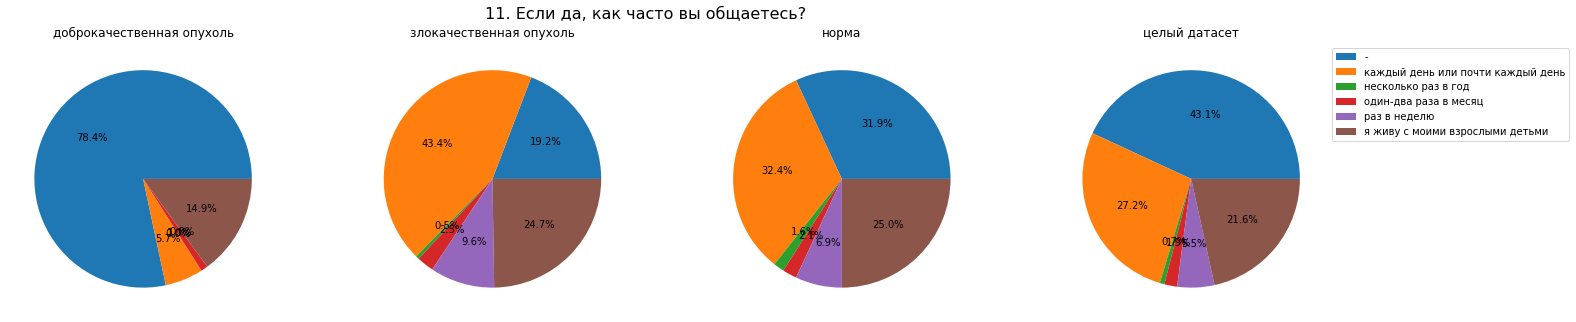

In [23]:
viz.plot_pies(df, defs.QUESTION_11, defs.LABEL)

### 12. Сколько человек живут вместе с Вами?

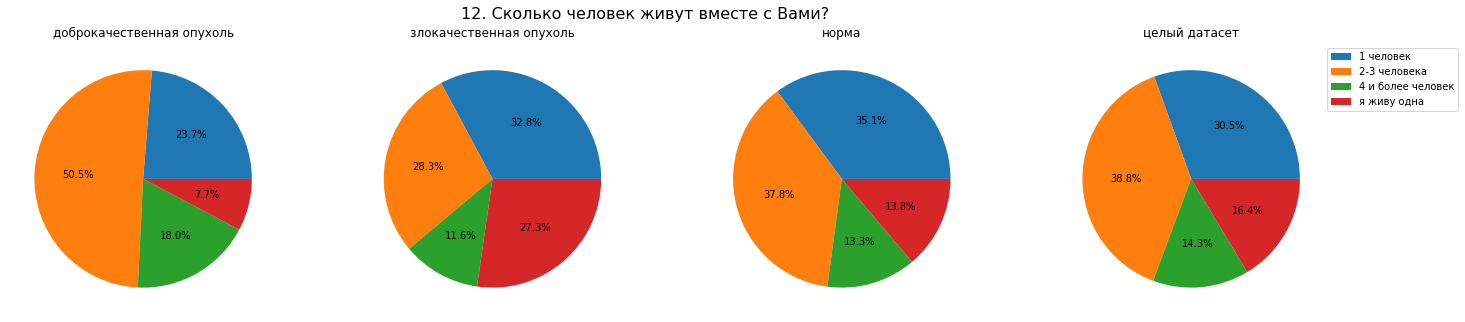

In [24]:
viz.plot_pies(df, defs.QUESTION_12, defs.LABEL)

### 13. Каковы Ваши взаимоотношения с соседями?

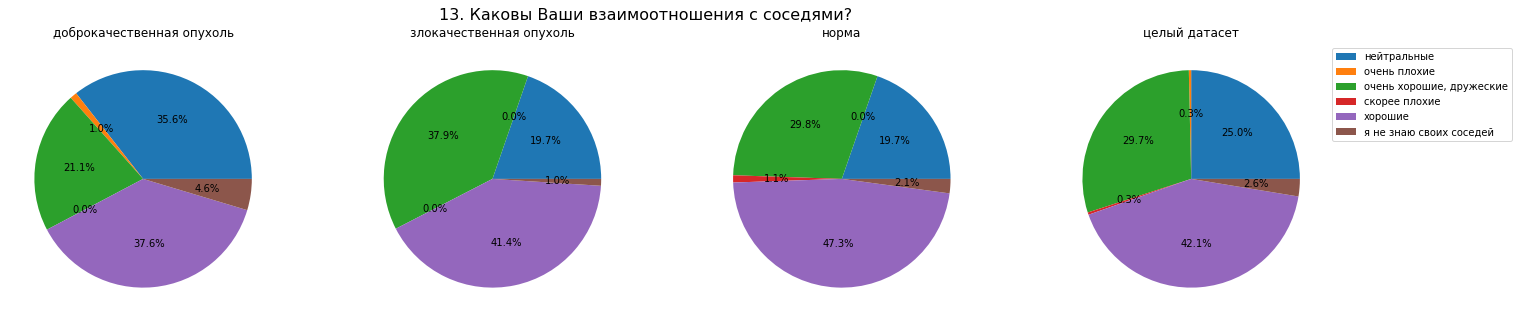

In [25]:
viz.plot_pies(df, defs.QUESTION_13, defs.LABEL)

### 14. Как часто Вы встречаетесь с друзьями?

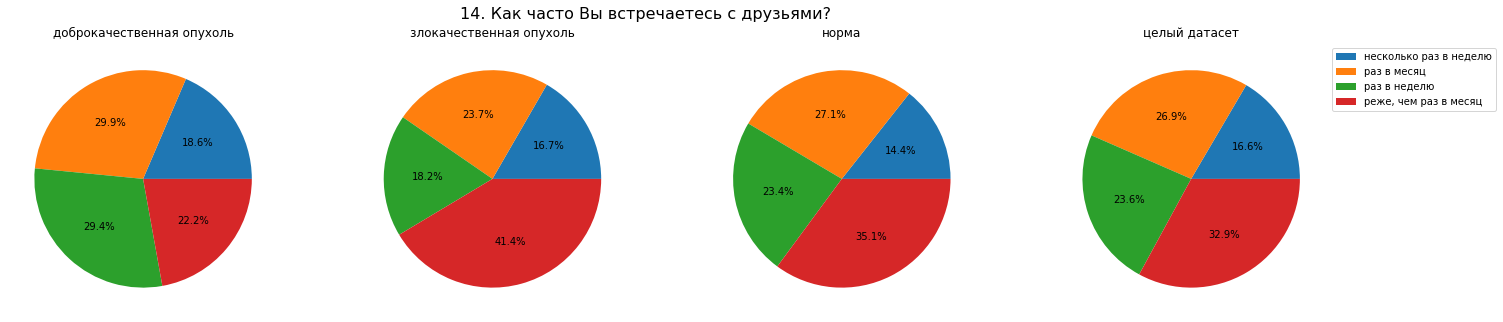

In [26]:
viz.plot_pies(df, defs.QUESTION_14, defs.LABEL)

### 15. Есть ли у Вас домашние питомцы? (да/нет)

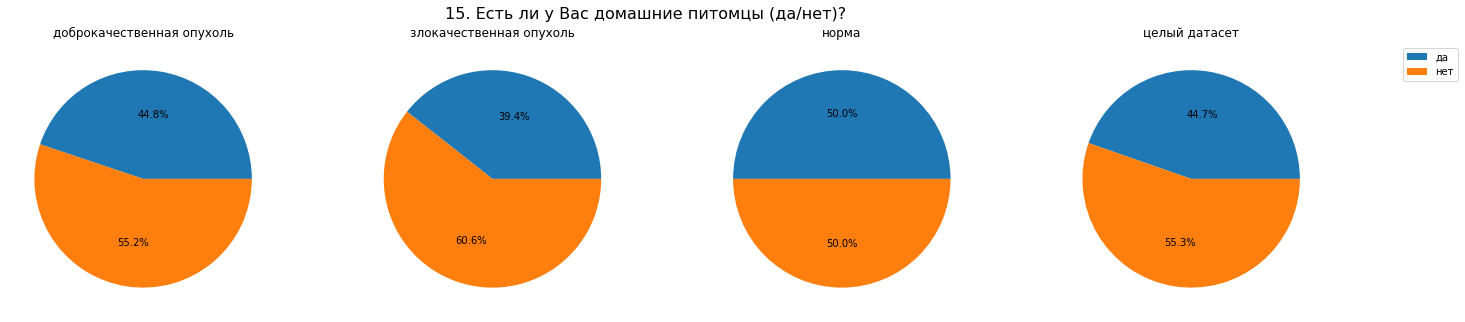

In [27]:
viz.plot_pies(df, defs.QUESTION_15, defs.LABEL)

### 16. В течение последних 7 дней, как часто Вы практиковали тяжелые физические нагрузки?

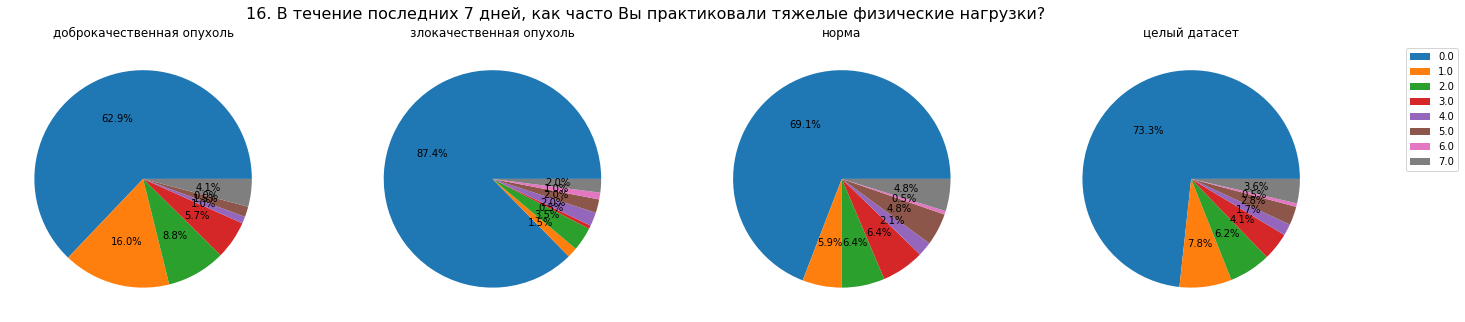

In [28]:
viz.plot_pies(df, defs.QUESTION_16, defs.LABEL)

### 17. В течение последних 7 дней, как часто Вы практиковали умеренные физические нагрузки?

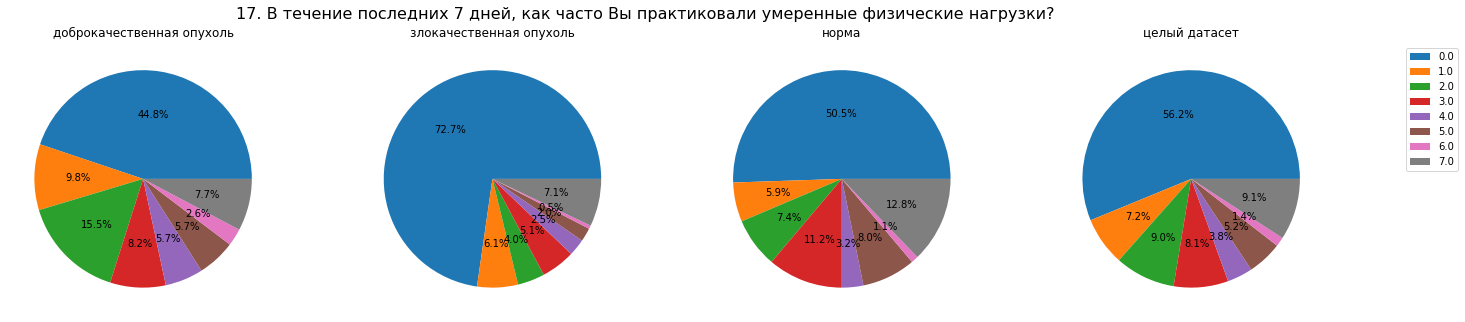

In [29]:
viz.plot_pies(df, defs.QUESTION_17, defs.LABEL)

### 18. В течение последних 7 дней, как часто Вы ходили пешком минимум 10 минут без перерыва?

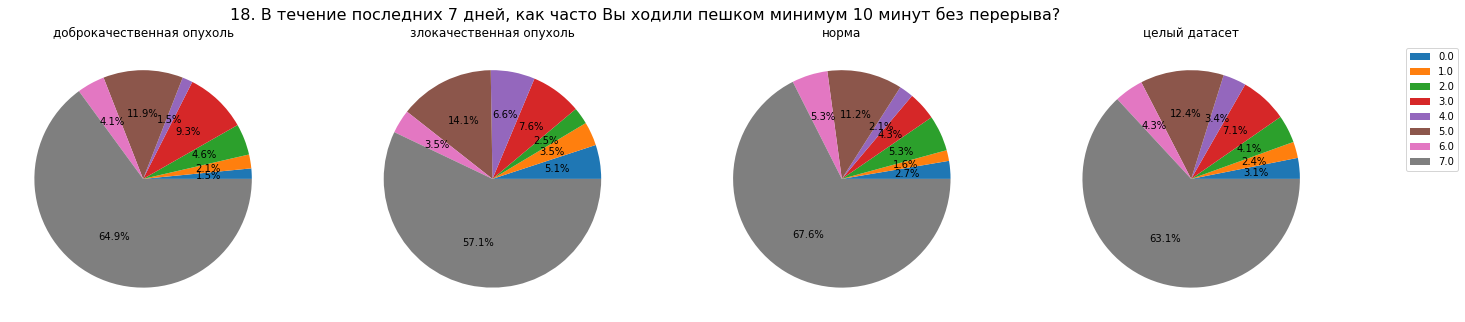

In [30]:
viz.plot_pies(df, defs.QUESTION_18, defs.LABEL)

### 19. Уровень Вашего образования?

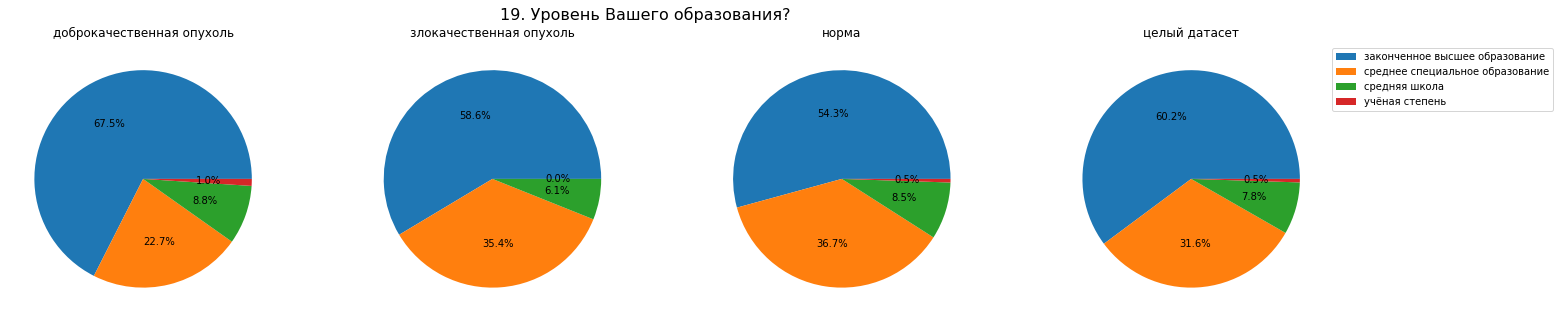

In [31]:
viz.plot_pies(df, defs.QUESTION_19, defs.LABEL)

### 20. Каков уровень образования Вашего партнёра? (если применимо)

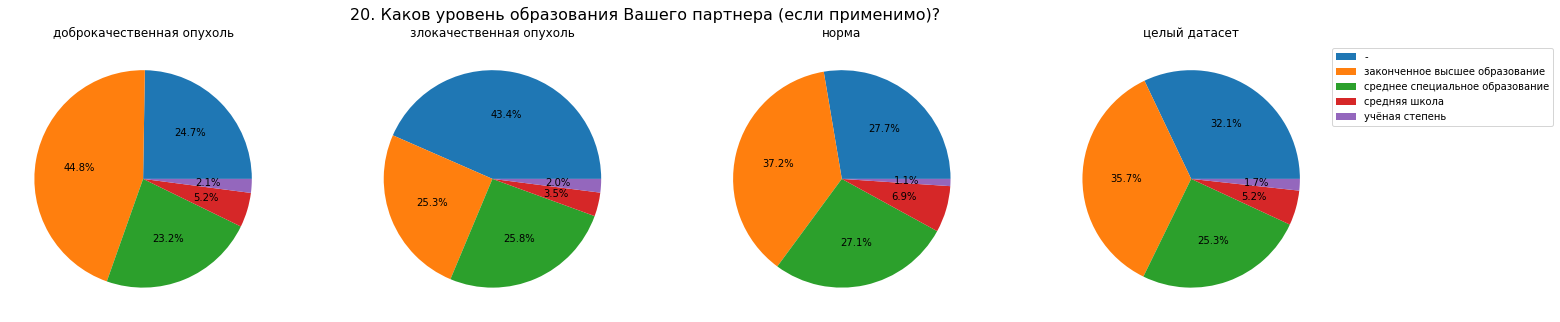

In [32]:
viz.plot_pies(df, defs.QUESTION_20, defs.LABEL)

### 22. Как долго Вы проживаете в этом месте? (в годах)

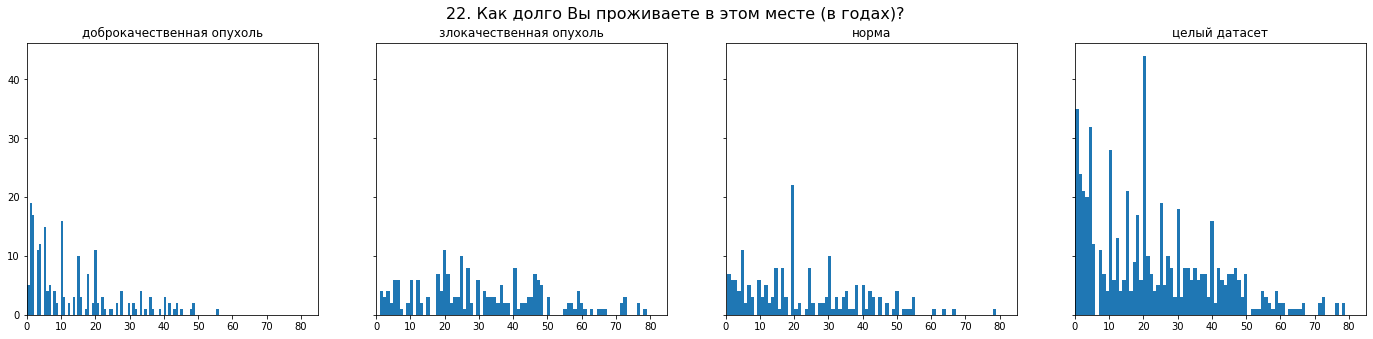

In [33]:
viz.plot_hists(df, defs.QUESTION_22, defs.LABEL, bins=80, xlim=(0, 85))

### 23. Каков тип Вашего дома?

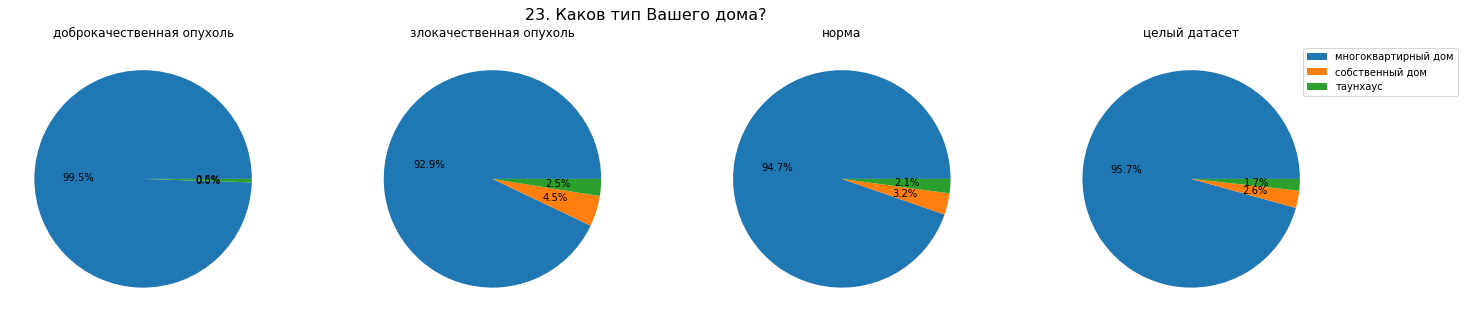

In [34]:
viz.plot_pies(df, defs.QUESTION_23, defs.LABEL)

### 24. Если Вы живёте в многоквартирном доме, то на каком этаже?

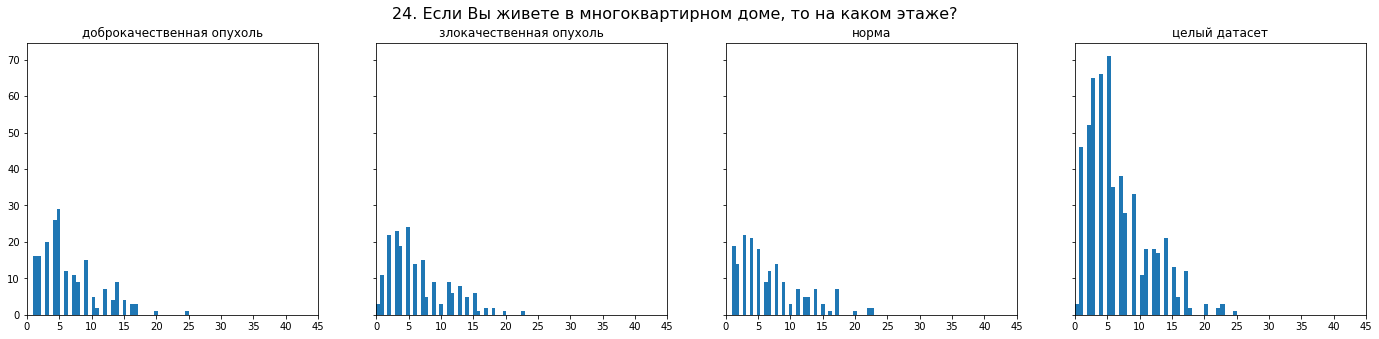

In [35]:
viz.plot_hists(df, defs.QUESTION_24, defs.LABEL, bins=40, xlim=(0, 45))

### 25. Каким транспортом Вы обычно пользуетесь?

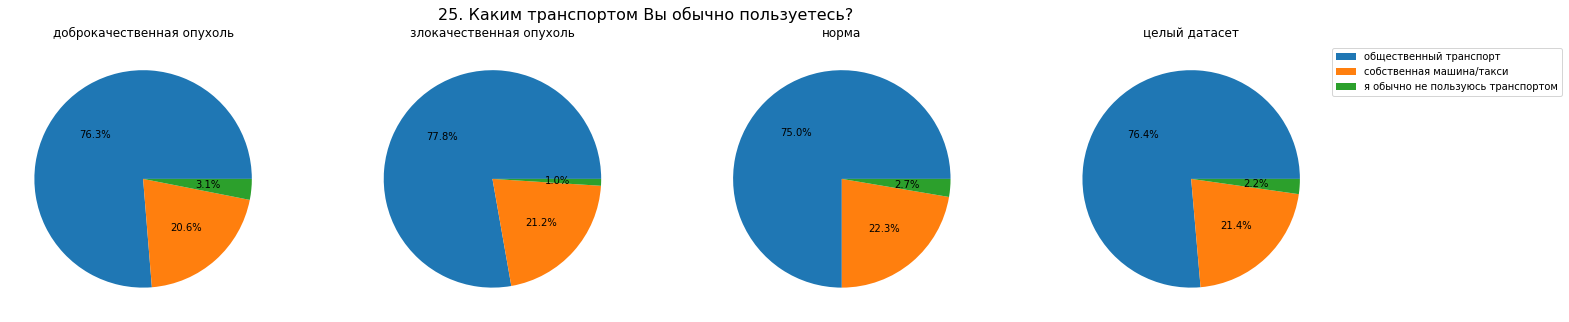

In [36]:
viz.plot_pies(df, defs.QUESTION_25, defs.LABEL)

### 26. Сколько времени занимает Ваш путь до работы в одну сторону?

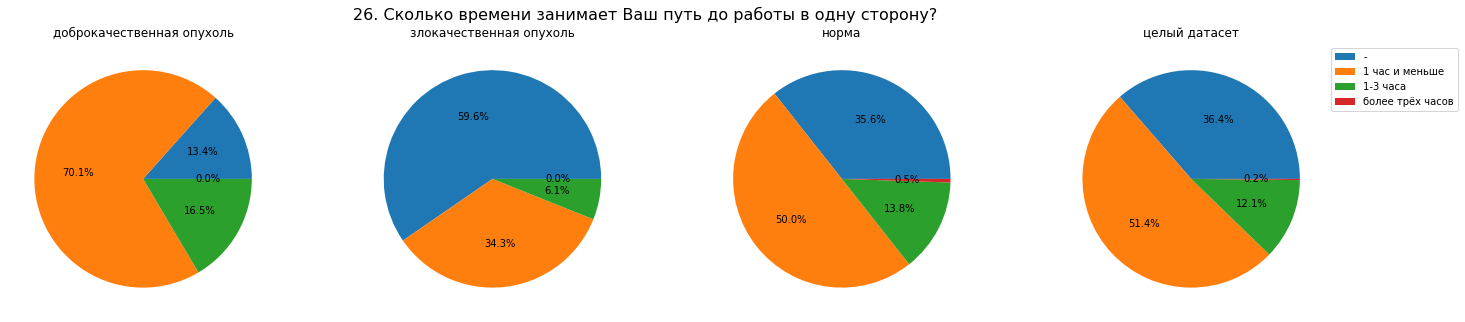

In [37]:
viz.plot_pies(df, defs.QUESTION_26, defs.LABEL)

### 27. Каков тип Вашей занятости?

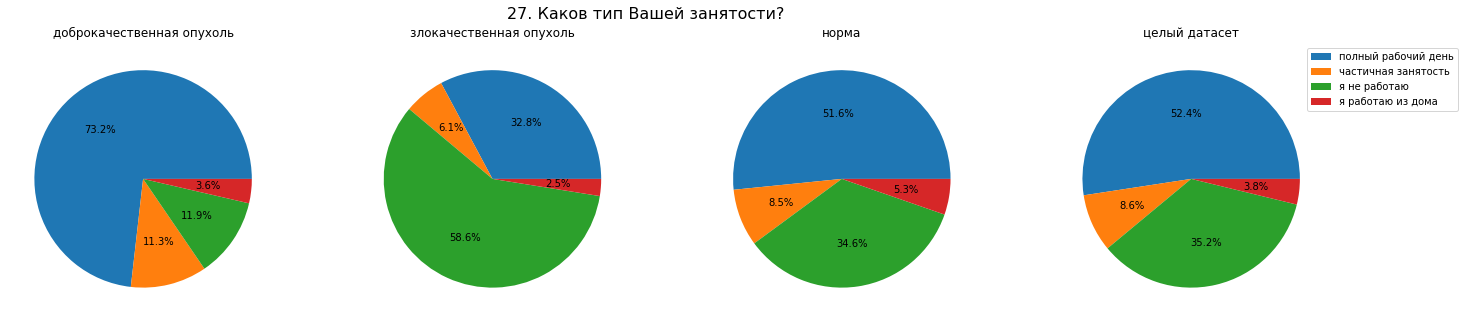

In [38]:
viz.plot_pies(df, defs.QUESTION_27, defs.LABEL)

### 28. Каковы Ваши предпочтения в пище?

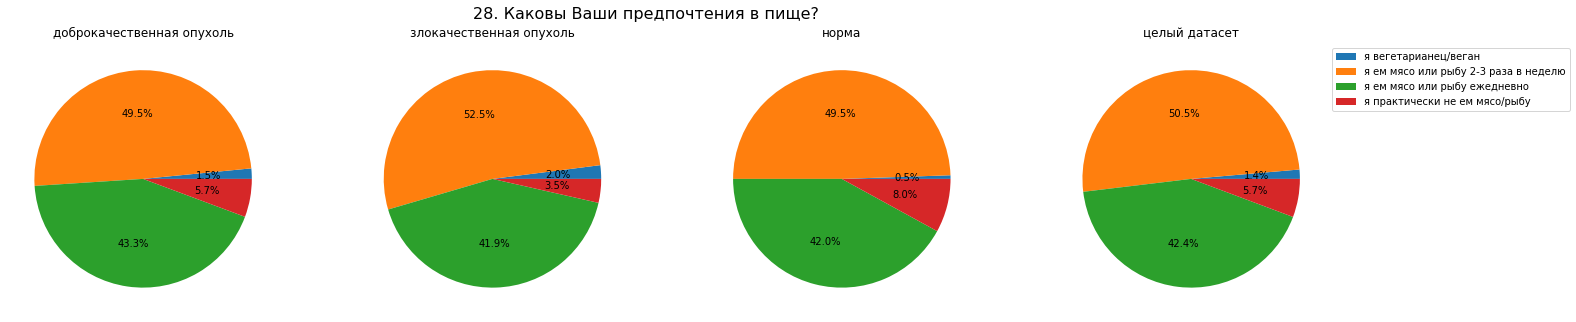

In [39]:
viz.plot_pies(df, defs.QUESTION_28, defs.LABEL)

### 29. Каков тип Вашего питания?

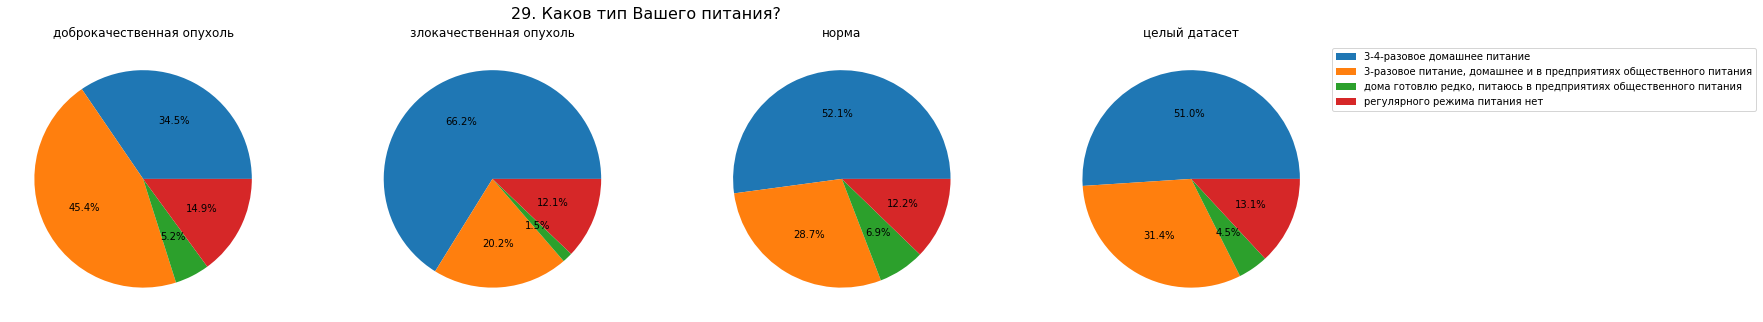

In [40]:
viz.plot_pies(df, defs.QUESTION_29, defs.LABEL)

### 30. Вы курите? (да/нет)

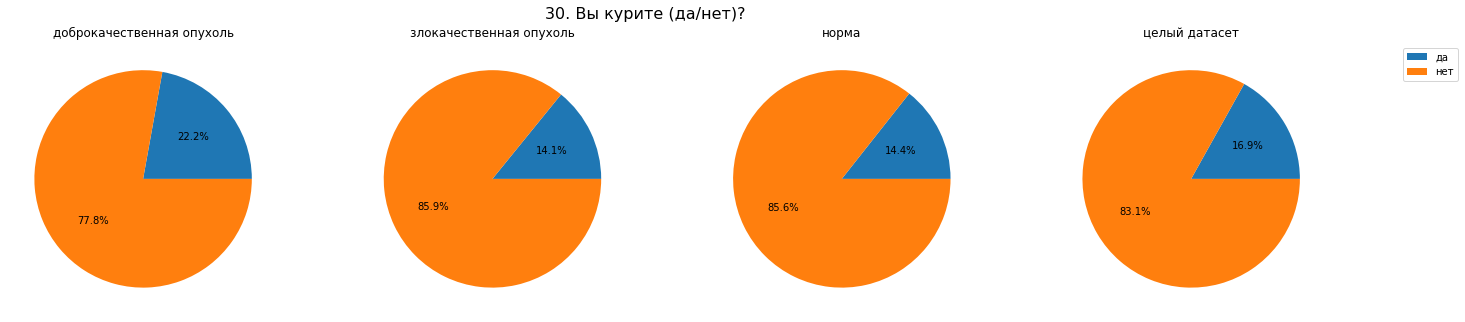

In [41]:
viz.plot_pies(df, defs.QUESTION_30, defs.LABEL)

### 31. Количество родов

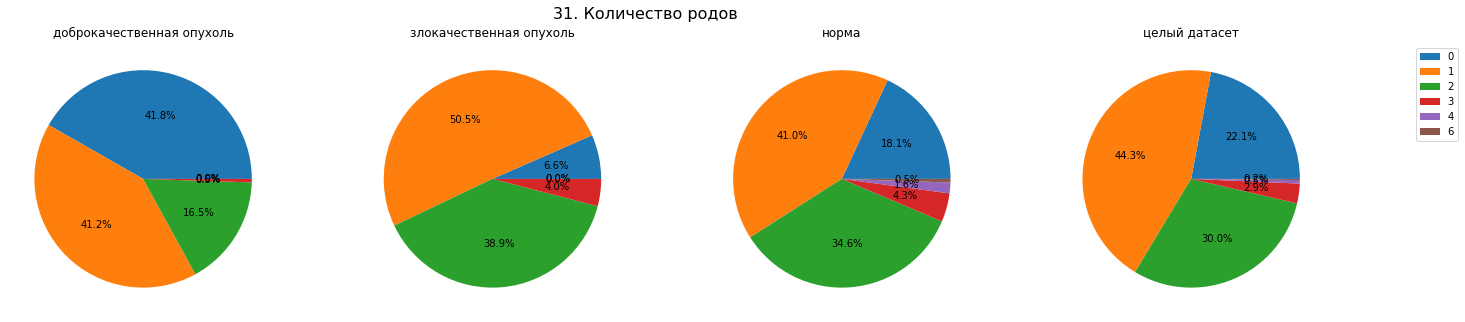

In [42]:
viz.plot_pies(df, defs.QUESTION_31, defs.LABEL)

### 32. Количество прерванных беременностей

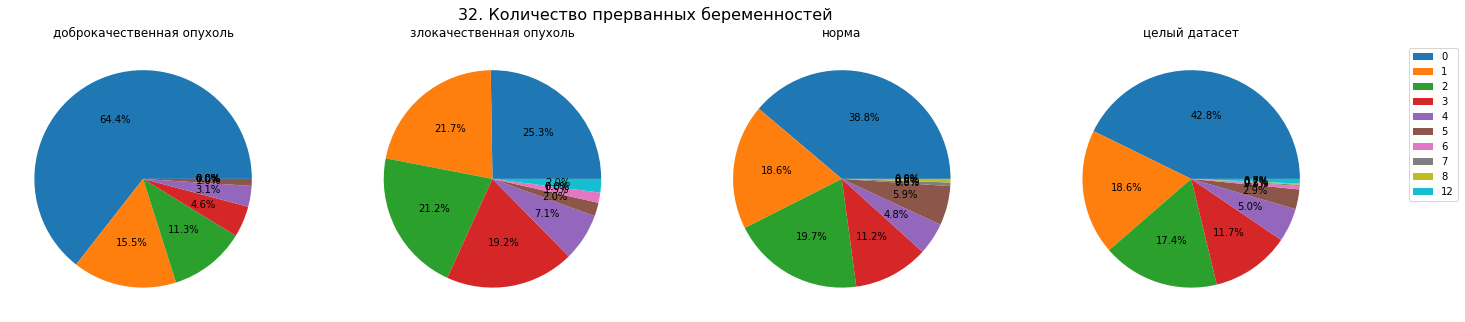

In [43]:
viz.plot_pies(df, defs.QUESTION_32, defs.LABEL)

### 33. Гинекологические заболевания (да/нет)

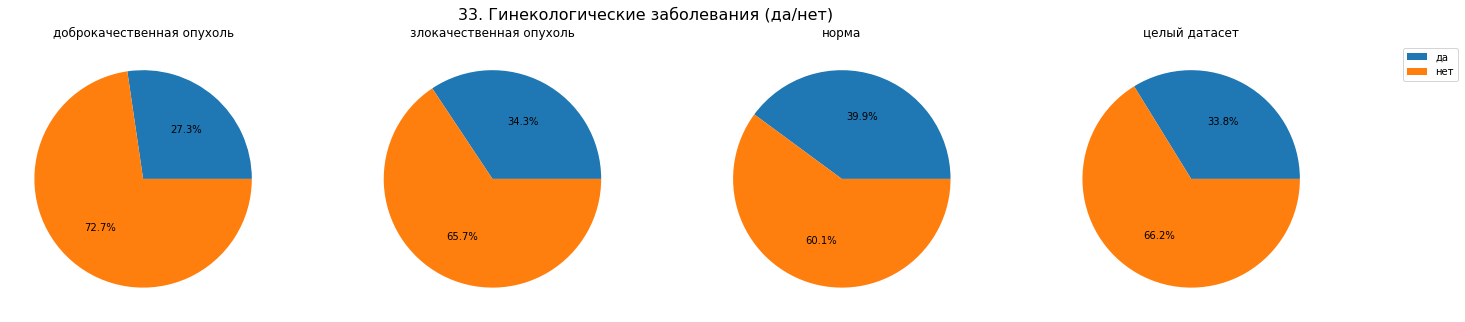

In [44]:
viz.plot_pies(df, defs.QUESTION_33, defs.LABEL)

### 34. Заболевания щитовидной железы (да/нет)

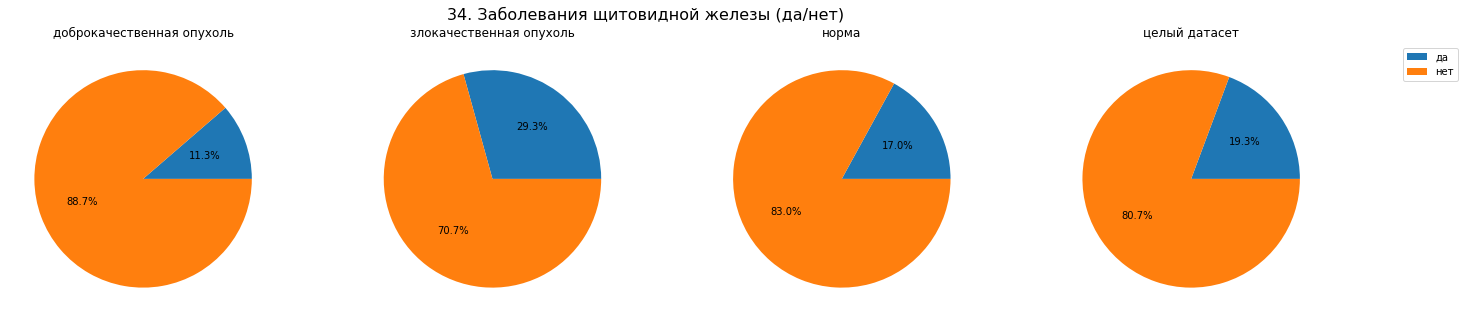

In [45]:
viz.plot_pies(df, defs.QUESTION_34, defs.LABEL)

### 35. Наследственность (да/нет)

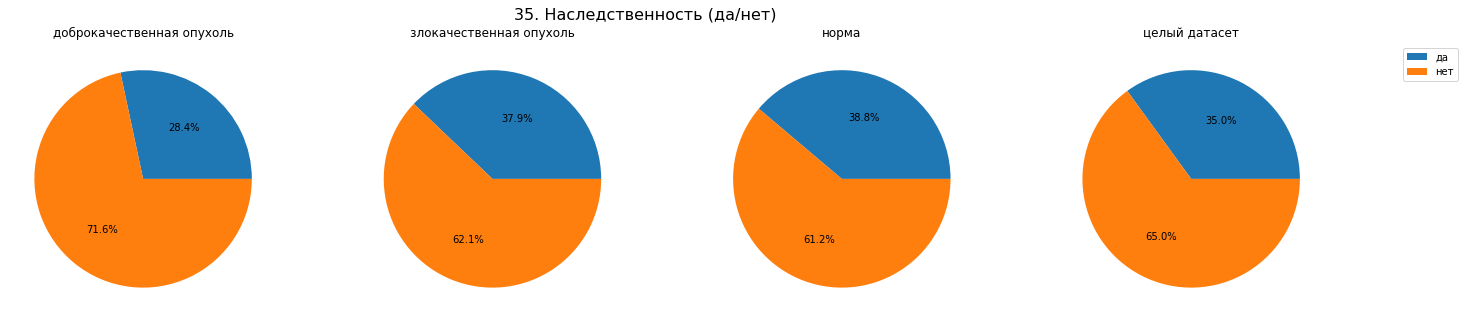

In [46]:
viz.plot_pies(df, defs.QUESTION_35, defs.LABEL)